# **Тема проекта**
 Обучение нейронной сети для мультиклассификации эмоций, которые выражены в посте социальной сети Твиттер.

**Исполнители**: Самойленко Ева, Смирнова Глафира

**Датасет**: Twitter Emotion Classification Dataset
https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset/data

The "Emotion" dataset consists of 416,809 English-language Twitter messages categorized into six basic emotions: anger, fear, joy, love, sadness, and surprise.


**Задача**: Улучшить скору как в рамках классических, так и в рамках нейросетевых подходов и проанализировать наиболее качественное решение

In [ ]:
!pip install nltk
!pip install gensim

Проведём все необходимые импорты и посмотрим на выбранный датасет.

In [ ]:
import pandas as pd
import spacy
import nltk
import string
import numpy as np
import gensim
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from google.colab import drive
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/twitter/twitter_emotions_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df.set_index('Unnamed: 0')
df.index.name = None
df.sample(10)

,text,label
163536,i feel crappy and start to cry myself,0
50218,i think i am not rlly prepared for it thats wh...,4
77576,i do at least feel reasonably virtuous about m...,1
85125,i got up and went for a run despite feeling gr...,0
126562,i feel so isolated and no matter how much i tr...,0
273597,i am feeling really rotten this morning,0
90388,i know this is abnormal for someone who isn t ...,0
352313,i feel that heineken is just popular import beer,1
398911,i just feel kinda helpless and frustrated a hr...,0
147543,i feel unwelcome at home quite the opposite ac...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


In [ ]:
df['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


Датасет состоит из **416.809** строк. По исчислению значений эмоций видно, что пользователи Твиттера слишком жизнерадостные люди (что странно), настолько, что в датасете происходит значительный перевес в 10! раз между крайними классами эмоции. Далее мы посмотрим, каким образом это повлияет на нашу модель.

In [ ]:
df_og = df.copy()

In [ ]:
## df = df_og.copy()

# Этап 1. Обучение модели с нуля

## Предобработка текста

Разделим наш датасет на обучающую и тестовую выборки.

In [ ]:
X_data = df['text']
y_data = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

X_train.to_csv('/content/drive/MyDrive/twitter/X_train.csv')
X_test.to_csv('/content/drive/MyDrive/twitter/X_test.csv')
y_train.to_csv('/content/drive/MyDrive/twitter/y_train.csv')
y_test.to_csv('/content/drive/MyDrive/twitter/y_test.csv')


print("Дата для обучения (текст поста):", X_train.shape)
print("Дата для тестирования (текст поста):", X_test.shape)
print("Дата для обучения (класс эмоции):", y_train.shape)
print("Дата для тестирования (класс эмоции):", y_test.shape)

Дата для обучения (текст поста): (333447,)
Дата для тестирования (текст поста): (83362,)
Дата для обучения (класс эмоции): (333447,)
Дата для тестирования (класс эмоции): (83362,)


### Нормализация постов

Облегчим работу наших моделей путём предобработки текста и приведения его к нормальному виду.

- Приведём текст постов к нижнему регистру,
- Разбитие каждого поста на токены и удаление путнктуации,
- Лемматизация слов (токенов),
- Удаление стоп-слов.

In [ ]:
X_train, X_test = X_train.to_frame(), X_test.to_frame()

In [ ]:
nltk.download('stopwords')

custom_stop_words = stopwords.words('english')
custom_stop_words.append('I')
stop_words = set(custom_stop_words)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    lemmas = [token.lemma_ for token in nlp(text)]
    # tokens = word_tokenize(text)
    tokens = [word for word in lemmas if word not in stop_words]
    return ' '.join(tokens)

X_train['tokens'] = X_train.text.apply(preprocess)
X_test['tokens'] = X_test.text.apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train.to_csv('/content/drive/MyDrive/twitter/x_train_tokens.csv')

X_train.sample(10)

,text,tokens
47160,i have to have the feeling to love to trust to...,feeling love trust care xys know keen
398791,i feel like youve hated me ever since i was bo...,feel like hate ever since bear wish never bear
398442,i am feeling completely happy,feel completely happy
370728,i feel like i always attract string loving pas...,feel like always attract string love passionat...
198155,i made it to the weigh bridge and back feeling...,make weigh bridge back feel grief precious mem...
380440,ive been working on a super long one but ive j...,work super long one let feel like much family ...
390777,im feeling like crap when i do it but i feel r...,feel like crap feel really proud
74623,when i got to know about the reaction of a fri...,get know reaction friend mine certain situatio...
20855,i can go denis tries to stand up but feels ale...,go denis try stand feel alex drag back grip fe...
125792,i feel like a hot mess a href http juliesjunkd...,feel like hot mess href http juliesjunkdrawer


In [ ]:
X_test.to_csv('/content/drive/MyDrive/twitter/x_test_tokens.csv')

X_test.sample(10)

,text,tokens
197512,i feel like there where some missed opportunit...,feel like miss opportunity come depict brainia...
233106,i must admit i feel a bit like a rockstar whic...,must admit feel bit like rockstar funny consid...
365289,i don t feel like doing anything today except ...,feel like anything today except crawl back bed...
312448,im not really feeling anything special i did s...,really feel anything special something somethi...
344085,i can feel it myself when i am reading online ...,feel read online look cute little vintage type...
6584,i feel very uptight about it when it happened ...,feel uptight happen yesterday immediately star...
313551,i will try my best to hold it my heart may fee...,try good hold heart may feel squeeze eye may g...
353638,i if i m feeling glamorous,feel glamorous
42583,i feel like a horribly boring person because o...,feel like horribly boring person
303095,i feel that the eager souls in us wanted to kn...,feel eager soul want know next


В результате предобработки получаем списки токенов - содержания постов, которые приведены к нормальному состоянию, что способствует улучшению качества модели. Сохраняем на чёрный день.

In [ ]:
X_train, X_test = pd.read_csv('/content/drive/MyDrive/twitter/x_train_tokens.csv'), pd.read_csv('/content/drive/MyDrive/twitter/x_test_tokens.csv')
X_train, X_test = X_train.set_index('Unnamed: 0'), X_test.set_index('Unnamed: 0')
X_train['tokens'], X_test['tokens'] = X_train.tokens.astype(str), X_test.tokens.astype(str)
X_train.index.name = None
X_test.index.name = None

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333447 entries, 146122 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    333447 non-null  object
 1   tokens  333447 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [ ]:
y_train, y_test = pd.read_csv('/content/drive/MyDrive/twitter/y_train.csv'), pd.read_csv('/content/drive/MyDrive/twitter/y_test.csv')
y_train, y_test = y_train.set_index('Unnamed: 0'), y_test.set_index('Unnamed: 0')
y_train.index.name = None
y_test.index.name = None

In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333447 entries, 146122 to 121958
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   label   333447 non-null  int64
dtypes: int64(1)
memory usage: 5.1 MB


## Векторизация текста

Воспользуемся библиотекой **Word2Vec**. Вдруг получится что-то дельное.

**Word2Vec** принимает большой *текстовый корпус* в качестве входных данных и сопоставляет каждому слову **вектор**, выдавая координаты слов на выходе. Сначала он генерирует *словарь* корпуса, а затем вычисляет *векторное представление слов*, «обучаясь» на входных текстах. Векторное представление основывается на **контекстной близости**: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, имеющие схожий смысл), будут иметь близкие (по косинусному расстоянию) векторы.

> vec(“king”) - vec(“man”) + vec(“woman”) =~ vec(“queen”)



In [ ]:
sentences = [sentence.split() for sentence in X_train['tokens']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
def vectorize_tokens(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if len(vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(vectors, axis=0)

X_train['vectorized_tokens'] = X_train.tokens.apply(vectorize_tokens)
X_test['vectorized_tokens'] = X_test.tokens.apply(vectorize_tokens)

In [ ]:
X_train.sample(10)

,text,tokens,vectorized_tokens
392513,i just wanted to share this because i feel you...,want share feel view input suggestion importan...,"[-0.13314696, 0.5624272, 0.02997134, 0.0477364..."
50267,i was always feeling ashamed of my body when i...,always feel ashamed body low high,"[-0.12649754, 0.5596894, -0.0034506875, 0.1433..."
129872,i will feel gloomy because i choose to,feel gloomy choose,"[-0.19356592, 0.66148585, -0.112031154, 0.1990..."
397202,i think you misunderstood i feel blamed,think misunderstood feel blame,"[-0.17645274, 0.6027041, 0.02372306, 0.1069268..."
336850,ive been feeling the divine every time i am gr...,feel divine every time greet namaste think hea...,"[-0.22988407, 0.64870065, 0.0033625271, 0.1993..."
66533,i need to be traveling to see someone in order...,need travel see someone order expense time fee...,"[-0.20629412, 0.6927291, -0.13607696, 0.167172..."
304979,i think because i am feeling neurotic and craz...,think feel neurotic crazy exasperate also feel...,"[-0.22157049, 0.65139115, -0.042950846, 0.1514..."
115004,i feel agitated and jumpy and like i just ate ...,feel agitated jumpy like eat bottle caffeine pill,"[-0.17401189, 0.5701379, -0.072419755, 0.16384..."
276621,i do though it makes me feel slutty,though make feel slutty,"[-0.14796345, 0.5546077, -0.032536797, 0.01435..."
306330,i feel like i am envious of the girl with long...,feel like envious girl long luscious hair big ...,"[-0.13688424, 0.5754862, -0.004204913, 0.05818..."


In [ ]:
word2vec_model.wv.most_similar(positive=['weird'], topn=5)

[('strange', 0.7861198782920837),
 ('awkward', 0.7292380928993225),
 ('funny', 0.7007780075073242),
 ('paranoid', 0.6737101078033447),
 ('obnoxious', 0.667233943939209)]

На тестовых словах модель Word2Vec работает неплохо. Введём её в наш контекст.

## Обучение модели - классификация

Используем **Метод опорных векторов** (Support Vector Classification) для обучения модели, так как наш датасет довольно объёмный, но мы не хотим разбрасываться памятью.

In [ ]:
X = np.vstack(X_train['vectorized_tokens'].values)

In [ ]:
clf = LinearSVC()
clf.fit(X, y_train)

LinearSVC()

In [ ]:
testing_X = np.vstack(X_test['vectorized_tokens'].values)
y_pred = clf.predict(testing_X)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.49      0.43     24504
           1       0.40      0.72      0.51     28247
           2       0.00      0.00      0.00      6853
           3       0.50      0.00      0.00     11339
           4       0.36      0.00      0.00      9376
           5       0.43      0.04      0.08      3043

    accuracy                           0.39     83362
   macro avg       0.34      0.21      0.17     83362
weighted avg       0.37      0.39      0.30     83362



Результаты получили посредственные, accuracy = 0.39 надо повысить. Посмотрим, что можно улучшить.

---

Попробуем поэкспериментировать с параметрами модели векторизации и модели метода опорных векторов.

In [ ]:
sentences = [sentence.split() for sentence in X_train['tokens']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=10, min_count=2, workers=4)
# увеличение размера векторов приводит к более точной семантике слова
# увеличение окна позволяет лучше рассмотреть слово в контексте предложения
# слово должно встретиться в корпусе как минимум 2 раза (а не 5 из прошлой модели), чтобы увеличить словарь модели

def vectorize_tokens(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if len(vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(vectors, axis=0)

X_train['vectorized_tokens'] = X_train.tokens.apply(vectorize_tokens)
X_test['vectorized_tokens'] = X_test.tokens.apply(vectorize_tokens)

In [ ]:
word2vec_model.wv.most_similar(positive=['weird'], topn=5)

[('strange', 0.8031338453292847),
 ('awkward', 0.7432995438575745),
 ('funny', 0.7238491177558899),
 ('paranoid', 0.7180603742599487),
 ('uptight', 0.7001668810844421)]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# чтобы снизить влияние классов, преобладающих в датасете (1 - радость/счастье), и соответственно повысить важность малопредставленных классов (5 - удивление)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
X = np.vstack(X_train['vectorized_tokens'].values)
testing_X = np.vstack(X_test['vectorized_tokens'].values)

clf = LinearSVC(class_weight=class_weight_dict)
clf.fit(X, y_train)

y_pred = clf.predict(testing_X)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.46      0.42     24504
           1       0.42      0.53      0.47     28247
           2       0.13      0.05      0.07      6853
           3       0.20      0.09      0.12     11339
           4       0.18      0.13      0.15      9376
           5       0.17      0.27      0.21      3043

    accuracy                           0.36     83362
   macro avg       0.25      0.25      0.24     83362
weighted avg       0.32      0.36      0.33     83362



Получилось избавиться от нулевых показателей, но accuracy понизилась с 0.39 до 0.36. Так не дело:(

---

Попробуем сменить подход и воспользоваться **TF-IDF векторизацией**.

**TF-IDF** вычисляет *важность* каждого слова в документе относительно *количества* его употреблений **в данном документе** и **во всей коллекции** текстов. Этот метод позволяет выделить ключевые слова и понять, какие слова имеют больший вес для определенного документа в контексте всей коллекции.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 5))
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train["tokens"])
X_test_vectorized = tfidf_vectorizer.transform(X_test["tokens"])

clf = LinearSVC()
clf.fit(X_train_vectorized, y_train)

pred = clf.predict(X_test_vectorized)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     24504
           1       0.91      0.91      0.91     28247
           2       0.70      0.70      0.70      6853
           3       0.89      0.88      0.89     11339
           4       0.82      0.82      0.82      9376
           5       0.68      0.66      0.67      3043

    accuracy                           0.88     83362
   macro avg       0.82      0.82      0.82     83362
weighted avg       0.88      0.88      0.88     83362



Вот это результат! Accuracy = 0.88 - это что-то!

---

Посмотрим, что скажет классификация на основе логистической регрессии **LogisticRegression** с изначальным Word2Vec векторизатором.


In [ ]:
sentences = [sentence.split() for sentence in X_train['tokens']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=10, min_count=2, workers=4)

def vectorize_tokens(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if len(vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(vectors, axis=0)

X_train['vectorized_tokens'] = X_train.tokens.apply(vectorize_tokens)
X_test['vectorized_tokens'] = X_test.tokens.apply(vectorize_tokens)

X = np.vstack(X_train['vectorized_tokens'].values)
testing_X = np.vstack(X_test['vectorized_tokens'].values)

classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
classifier.fit(X, y_train)

y_pred = classifier.predict(testing_X)

NameError: name 'classification_report' is not defined

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.49      0.43     24504
           1       0.40      0.72      0.51     28247
           2       0.00      0.00      0.00      6853
           3       0.36      0.00      0.01     11339
           4       0.35      0.00      0.01      9376
           5       0.43      0.04      0.07      3043

    accuracy                           0.39     83362
   macro avg       0.32      0.21      0.17     83362
weighted avg       0.35      0.39      0.30     83362



Результат не радует. Он схож с цифрами Метода опорных векторов. Может проблема в методе векторизации? Проверим.

---

Воспользуемся **Логистической регрессией** в совокупности с **TF-IDF векторизацией**.

Из-за проблем с ОЗУ пришлось снизить размер n-грамм, но это не помешало успешной работе модели. Взгляните какой результат!

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train["tokens"])
X_test_vectorized = tfidf_vectorizer.transform(X_test["tokens"])

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train_vectorized, y_train.label)

y_pred = classifier.predict(X_test_vectorized)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NameError: name 'pred' is not defined

In [ ]:
print(classification_report(y_test.label, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     24504
           1       0.90      0.94      0.92     28247
           2       0.79      0.71      0.75      6853
           3       0.90      0.88      0.89     11339
           4       0.84      0.85      0.84      9376
           5       0.80      0.65      0.72      3043

    accuracy                           0.89     83362
   macro avg       0.86      0.83      0.84     83362
weighted avg       0.89      0.89      0.89     83362



Accuracy = 0.89 - это же охонь🔥



---



## Выводы по обучению модели с нуля

Большой датасет требует большой работы, но к счастью (а может и к сожалению), больше всего времени занимала преобработка текста. Лемматизация работала 35 минут для всего датасета, что вводило в депрессию.

Во время первого этапа были использованы следующие инструменты в разных парах:

-- Метод опорных векторов LinearSVC

-- Метод логистической регрессии LogisticRegression

  -> Word2Vec векторизация

  -> Векторизация TF-IDF

Выяснилось, что оба алгоритма обучения не сдружились с Word2Vec (может, характеры не подошли), а вот TF-IDF оказалась очень поддатливой и снисходительной по отношению к алгоритмам (идеальные пары!).

Эксперименты показали, что пара **LinearSVC + Word2Vec** совместима на минимальную **accuracy = 0.36**, а вот **LogisticRegression + TF-IDF = <3 = accuracy 0.89**.


# Этап 2. Предобученные модели

В бой!

Самое время предобученным моделям показать, на что они способны...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

x_train = pd.read_csv('/content/drive/MyDrive/twitter/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/twitter/y_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/twitter/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/twitter/y_test.csv')
df = pd.read_csv('/content/drive/MyDrive/twitter/twitter_emotions_dataset.csv')

Проверим, есть ли в датасете пустые строки: если это так, кластеры в эмбеддингах будут недовольны.

In [ ]:
empty_strings = df['text'].apply(lambda x: x == '')
nan_values = df['text'].isna()

print("Empty strings in 'text' column:", empty_strings.sum())
print("NaN values in 'text' column:", nan_values.sum())

Empty strings in 'text' column: 0
NaN values in 'text' column: 0


## Без дообучения

Без дообучения мы протестируем хорошо известную нам [bert-base-uncased](https://huggingface.co/google-bert/bert-base-uncased).

Это предобученная модель трансформера от Google, входящая в семейство моделей BERT. Она обучена на большом корпусе текстов (англоязычные Wikipedia и BooksCorpus), где все слова приведены к нижнему регистру (uncased).

Из известных недостатков - модель довольно тяжелая, требует много памяти и ресурсов GPU


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

TFBertForSequenceClassification - это модель из библиотеки Hugging Face Transformers, которая представляет собой BERT с дополнительным классификационным слоем на выходе.

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y_train["label"].unique()))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(list(x_test["text"]), truncation=True, padding=True, max_length=128, return_tensors="tf")


test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(2)
predictions = model.predict(test_dataset).logits
predicted_labels = tf.argmax(predictions, axis=1).numpy()

Немного теории: `test_encodings` - это словарь, где `input_ids` - токенизированные индексы слов, а `attention_mask` - маска, указывающая, какие токены настоящие, а какие — паддинг (пустые токены, чтобы все входные последовательности имели одинаковую длину)

`.logits` возвращает логиты (сырые выходы) из последнего слоя перед softmax, а `tf.argmax(predictions, axis=1)` находит индекс максимального значения (наибольшего лога) по каждой строке (т.е. для каждого текста). Это определяет наиболее вероятный класс.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test['label'], predicted_labels)
precision = precision_score(y_test['label'], predicted_labels, average='weighted')
recall = recall_score(y_test['label'], predicted_labels, average='weighted')
f1 = f1_score(y_test['label'], predicted_labels, average='weighted')
conf_matrix = confusion_matrix(y_test['label'], predicted_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.04
Precision: 0.12
Recall: 0.04
F1 Score: 0.00
Confusion Matrix:
[[   10     0   117     0     7 24370]
 [    7     0    99     1     4 28136]
 [    2     0    22     0     1  6828]
 [    6     0    65     0     2 11266]
 [    5     0    39     0     5  9327]
 [    3     0    10     0     2  3028]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ого, ниже еще не было!

Предлагаю оставить в покое недообученную модель и извлечь эмбеддинги!

## Эмбеддинги

### Падения

Мы дали **bert-base-uncased** 40 минут на раздумья (еще не зная, что это слишком быстро даже для легких моделей...)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch
import gc

class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Загрузка токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Параметры
max_len = 128
batch_size = 32

# Создание датасета и DataLoader
dataset = TwitterDataset(df["text"].tolist(), tokenizer, max_len)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

# Использование GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Получение эмбеддингов
embeddings = []
model.eval()
with torch.no_grad():
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        batch_embeddings = last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu())  # Перемещение на CPU для освобождения памяти GPU

        # Очистка памяти
        del input_ids, attention_mask, outputs, last_hidden_state, batch_embeddings
        torch.cuda.empty_cache()
        gc.collect()

# Объединение эмбеддингов
embeddings = torch.cat(embeddings, dim=0)

print(embeddings)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

Похоже, модель слишком тяжелая для нас!

Рассмотрим что-нибудь полегче...



---



Знакомимся с [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5#usage).

Это компактная версия трансформера с уменьшенным числом параметров, что делает её быстрой и подходящей для задач с ограниченными ресурсами. Подходит для создания эмбеддингов в многоклассовых классификациях или поисковых задачах.



In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

# Токенизация текстов
inputs = tokenizer(list(df["text"]), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [ ]:
# Отключаем градиенты, т.к. дообучения не будет
with torch.no_grad():
    outputs = model(**inputs)

# Получаем эмбеддинги из последнего слоя
last_hidden_state = outputs.last_hidden_state

# Используем CLS-токен (первый токен) для представления текста
cls_embeddings = last_hidden_state[:, 0, :]

На моменте `inputs = tokenizer(list(df["text"]), padding=True, truncation=True, return_tensors="pt")` что-то мы надолго зависли.

А не связано ли это с размером датасета в 417 тысяч строк?

Придется разбивать все на батчи и обрабатывать постепенно

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset

class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()}

# Параметры
max_len = 128
batch_size = 32

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

# Создание датасета и DataLoader
dataset = TwitterDataset(df["text"].tolist(), tokenizer, max_len)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

# Получение эмбеддингов
embeddings = []
model.eval()
with torch.no_grad():
    for batch in data_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

# Объединение эмбеддингов
embeddings = torch.cat(embeddings, dim=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

Опять долго работает, а RAM перегружена:(

Добавим логирование и очищение памяти, уменьшим размер батча и добавим распределение нагрузки между CPU и GPU!

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import gc
from tqdm import tqdm

class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()}

# Параметры
max_len = 128
batch_size = 16

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

# Использование GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Создание датасета и DataLoader
dataset = TwitterDataset(df["text"].tolist(), tokenizer, max_len)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

# Получение эмбеддингов
embeddings = []
model.eval()
with torch.no_grad():
    for batch in tqdm(data_loader, desc="Processing batches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu())  # Перемещение на CPU для освобождения памяти GPU

        # Очистка памяти
        del input_ids, attention_mask, outputs, batch_embeddings
        torch.cuda.empty_cache()
        gc.collect()

# Объединение эмбеддингов
embeddings = torch.cat(embeddings, dim=0)

print(embeddings)

Processing batches:   3%|▎         | 859/26051 [05:41<2:25:17,  2.89it/s]Exception ignored in: <function _xla_gc_callback at 0x78aaf2bd8820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Processing batches:   3%|▎         | 860/26051 [05:42<2:47:00,  2.51it/s]


RuntimeError: DataLoader worker (pid(s) 28068, 28070) exited unexpectedly

2.5 часа? Не на тех напали. Смена модели!

### Взлеты

Представляем Вашему вниманию [TaylorAI/bge-micro-v2](https://huggingface.co/TaylorAI/bge-micro-v2).


Она предназначена для генерации sentence embeddings (предложенческих эмбеддингов). Эти эмбеддинги можно использовать в задачах семантического поиска, кластеризации, классификации и других задачах обработки естественного языка (NLP). Модель оптимизирована по размеру и скорости работы.
Подходит для задач, где важны производительность и низкие вычислительные затраты - а это наш случай.

Обещает справиться за час-полтора, нам подходит. Поехали!

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import gc
from tqdm import tqdm

class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()}

# Параметры
max_len = 128
batch_size = 32  # Уменьшение размера батча для экономии памяти

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("TaylorAI/bge-micro-v2")
model = AutoModel.from_pretrained("TaylorAI/bge-micro-v2")

# Использование GPU, если доступно
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Создание датасета и DataLoader
dataset = TwitterDataset(df["text"].tolist(), tokenizer, max_len)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

# Получение эмбеддингов
embeddings = []
model.eval()
with torch.no_grad():
    for batch in tqdm(data_loader, desc="Processing batches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu())  # Перемещение на CPU для освобождения памяти GPU

        # Очистка памяти
        del input_ids, attention_mask, outputs, batch_embeddings
        torch.cuda.empty_cache()
        gc.collect()

# Объединение эмбеддингов
embeddings = torch.cat(embeddings, dim=0)

print(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

True


Processing batches:  89%|████████▊ | 11546/13026 [1:04:38<08:17,  2.98it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 171, in collate
    {
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 172, in <dictcomp>
    key: collate(
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [128] at entry 0 and [185] at entry 7


Вот так бывает! Спустя час слежки за процентами у нас рантайм - тензоры разного размера.

Нас тензорами не напугаешь, так что добавим-ка мы лучше truncation=True и запустим все заново!

Мы, конечно, уже отказывались от идеи ждать 2.5 часа, но терять уже нечего

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import gc
from tqdm import tqdm

class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Усечение текста до max_len
            return_token_type_ids=False,
            padding='max_length',  # Заполнение до max_len
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

# Параметры
max_len = 128
batch_size = 16  # Уменьшение размера батча

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("TaylorAI/bge-micro-v2")
model = AutoModel.from_pretrained("TaylorAI/bge-micro-v2")

# Использование GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Создание датасета и DataLoader
dataset = TwitterDataset(df["text"].tolist(), tokenizer, max_len)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

# Получение эмбеддингов
embeddings = []
model.eval()
with torch.no_grad():
    for batch in tqdm(data_loader, desc="Processing batches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1) # Содержит эмбеддинги всех токенов из последнего слоя модели
        # Усредняет эмбеддинги по всем токенам, получая эмбеддинг всего текста.
        embeddings.append(batch_embeddings.cpu())

        # Очистка памяти
        del input_ids, attention_mask, outputs, batch_embeddings
        torch.cuda.empty_cache()
        gc.collect()

# Объединение эмбеддингов
embeddings = torch.cat(embeddings, dim=0)

# Вывод эмбеддингов
print(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 26051/26051 [2:18:12<00:00,  3.14it/s]


tensor([[-0.2109,  0.1740,  0.2508,  ...,  0.1482, -0.1047, -0.2221],
        [-0.0590,  0.1297,  0.2614,  ...,  0.0339, -0.4697, -0.3233],
        [-0.4285,  0.0587,  0.3055,  ...,  0.3666, -0.0334, -0.1898],
        ...,
        [-0.2039,  0.2867,  0.4231,  ...,  0.2906, -0.5077, -0.3581],
        [-0.1260,  0.1544,  0.0790,  ...,  0.2072,  0.0175, -0.0041],
        [-0.1632,  0.2768,  0.2876,  ...,  0.1666, -0.0246, -0.4629]])


А вот и они! Красивые и стройные эмбеддинги весом почти 2 Гб. Сохраним. На всякий случай.

In [ ]:
embeddings_np = embeddings.numpy()
embeddings_df = pd.DataFrame(embeddings_np)
embeddings_df.to_csv('/content/drive/MyDrive/twitter/taylor_embeddings.csv', index=False)

**Логистическая регрессия**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

labels = df["label"].values

# Преобразование embeddings в numpy массив
embeddings_np = embeddings.numpy()

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(embeddings_np, labels, test_size=0.2, random_state=42)

# Инициализация и обучение логистической регрессии
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Прогнозирование
y_pred = clf.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7241548907175932
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76     24504
           1       0.75      0.83      0.79     28247
           2       0.60      0.42      0.49      6853
           3       0.69      0.63      0.66     11339
           4       0.69      0.64      0.66      9376
           5       0.65      0.52      0.58      3043

    accuracy                           0.72     83362
   macro avg       0.69      0.64      0.66     83362
weighted avg       0.72      0.72      0.72     83362



**Опорные вектора**

In [ ]:
import pandas as pd

embeddings = pd.read_csv('/content/drive/MyDrive/twitter/taylor_embeddings.csv')

In [ ]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.210906,0.173992,0.250793,-0.084255,-0.048643,-0.272874,0.453081,0.173415,0.466081,-0.056754,...,0.143237,-0.434470,0.019391,-0.026013,-0.250750,-0.048744,-0.165885,0.148249,-0.104712,-0.222076
1,-0.058970,0.129726,0.261395,0.164602,0.054653,-0.066499,0.467665,0.139318,0.476494,-0.413307,...,-0.032224,-0.232308,0.034836,-0.010985,-0.176707,-0.091012,-0.028004,0.033854,-0.469734,-0.323343
2,-0.428467,0.058658,0.305540,-0.010411,0.062668,-0.095420,0.147069,0.298938,0.178591,-0.044091,...,-0.091817,-0.203809,-0.086206,-0.075102,-0.187618,-0.241538,0.300572,0.366556,-0.033352,-0.189844
3,-0.330004,0.175958,0.130905,0.174684,-0.055167,0.159663,0.202109,0.300084,0.272030,-0.263251,...,0.011869,-0.591007,0.206252,-0.027025,-0.364579,-0.237100,-0.163554,0.362872,-0.527454,-0.100546
4,-0.144866,0.258318,0.257345,0.114812,-0.019071,-0.096522,0.550338,0.079643,0.303900,-0.131625,...,0.114249,-0.249703,0.097941,0.126035,-0.313929,-0.105481,0.070074,0.129228,-0.103612,-0.295228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416804,-0.220779,0.133051,0.153257,0.074179,0.004377,-0.193520,0.204871,0.365564,0.278236,0.017937,...,0.139260,-0.544072,0.071354,-0.120092,-0.101614,0.029362,0.224358,0.407765,-0.371204,-0.233208
416805,0.022443,0.000910,0.248963,0.120419,0.063592,-0.193731,0.378292,0.105061,0.254895,-0.157357,...,-0.032431,-0.257914,0.041268,0.032083,-0.041295,-0.113569,0.178884,0.023367,-0.237860,-0.174838
416806,-0.203881,0.286693,0.423070,0.128820,0.036255,0.010268,0.541814,0.029503,0.441143,-0.077048,...,0.030447,-0.453788,0.195131,0.013828,-0.091637,-0.112625,0.034636,0.290568,-0.507657,-0.358147
416807,-0.125981,0.154389,0.078968,0.212833,0.144374,0.343854,0.166126,0.384059,0.085599,-0.309486,...,0.089300,-0.594525,-0.112894,-0.044448,-0.035610,0.030421,0.236696,0.207199,0.017504,-0.004130


In [ ]:
embeddings_np = embeddings.values
embeddings_np

array([[-0.210906  ,  0.17399201,  0.25079322, ...,  0.1482492 ,
        -0.10471246, -0.22207576],
       [-0.05896977,  0.12972559,  0.26139534, ...,  0.03385402,
        -0.4697336 , -0.32334343],
       [-0.42846668,  0.05865847,  0.30554038, ...,  0.36655605,
        -0.03335188, -0.18984377],
       ...,
       [-0.20388094,  0.28669274,  0.42306983, ...,  0.2905678 ,
        -0.50765723, -0.3581469 ],
       [-0.125981  ,  0.15438916,  0.07896785, ...,  0.2071985 ,
         0.01750402, -0.00412957],
       [-0.16316849,  0.27680546,  0.28755417, ...,  0.16658214,
        -0.02463503, -0.46290296]])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Преобразование эмбеддингов в numpy
embeddings_np = embeddings.numpy()

X_train, X_test, y_train, y_test = train_test_split(embeddings_np, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()  # Стандартизация, тк SVM чувствителен к масштабу признаков
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание и обучение модели SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)  # Используем линейное ядро, C — сила регуляризации, "строгость" модели к ошибкам классификации.
svm.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = svm.predict(X_test)

# Оценка качества
print("Classification Report:")
print(classification_report(y_test, y_pred))

Долго, мы не такие терпеливые!

Обычная SCV, пусть даже с linear ядром, никуда не торопится.

Запустим LinearSVC!

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

labels = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(embeddings_np, labels, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение LinearSVC
linear_svm = LinearSVC(C=1.0, random_state=42, max_iter=1000)
linear_svm.fit(X_train_scaled, y_train)

# Предсказание
y_pred = linear_svm.predict(X_test_scaled)

# Оценка качества модели
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     24504
           1       0.73      0.85      0.79     28247
           2       0.63      0.32      0.42      6853
           3       0.70      0.60      0.65     11339
           4       0.70      0.62      0.66      9376
           5       0.69      0.42      0.52      3043

    accuracy                           0.72     83362
   macro avg       0.70      0.60      0.64     83362
weighted avg       0.71      0.72      0.71     83362



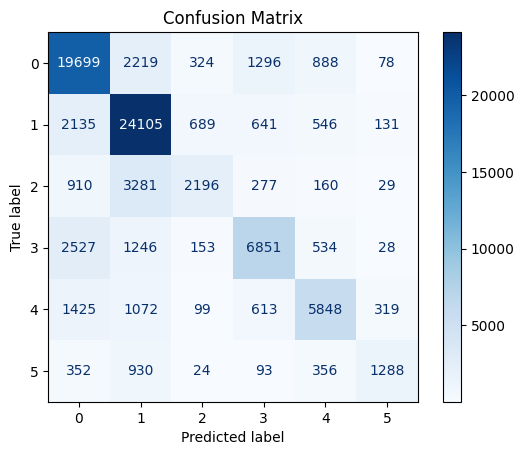

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svm.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'Blues' для лучшей читаемости
plt.title("Confusion Matrix")
plt.show()

Выводы:


1.   Мы отлично определяем грусть (0) и радость (1)!
2. Другой вопрос - почему мы часто их путаем..
3.   Любовь (2) мы чаще принимаем за радость(1), чем за любовь:D
4. А злость (3) за радость (1) как? Может, в высказываниях много сарказма, а может...



Кажется, классы 0 и 1 доминируют, попробуем сбалансировать классы с помощью class_weight='balanced'

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     24504
           1       0.81      0.75      0.78     28247
           2       0.48      0.57      0.52      6853
           3       0.65      0.68      0.66     11339
           4       0.63      0.67      0.65      9376
           5       0.46      0.73      0.56      3043

    accuracy                           0.71     83362
   macro avg       0.64      0.69      0.65     83362
weighted avg       0.72      0.71      0.71     83362



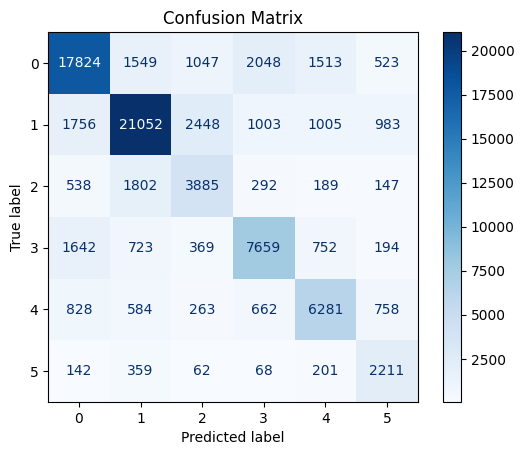

In [ ]:
linear_svm = LinearSVC(C=1.0, class_weight='balanced', random_state=42, max_iter=1000)
linear_svm.fit(X_train_scaled, y_train)
y_pred = linear_svm.predict(X_test_scaled)

# Оценка качества модели
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svm.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'Blues' для лучшей читаемости
plt.title("Confusion Matrix")
plt.show()

Скора такая же, а вот матрица нам нравится куда больше:


1.   По всей диагонали классы определены намного точнее
2.   Даже любовь(2) теперь чаще любовь, чем радость(1)



## Fine-tuning

0.71 - это неплохо, но мы должны обойти классический пайплайн!

Займемся дообучением предобученных моделей на нашем наборе данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

x_train = pd.read_csv('/content/drive/MyDrive/twitter/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/twitter/y_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/twitter/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/twitter/y_test.csv')
df = pd.read_csv('/content/drive/MyDrive/twitter/twitter_emotions_dataset.csv')

Во время розыска моделей, способных обработать наш немаленький датасет в разумные сроки, то и дело на глаза попадался [distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased).


 Это компактная версия модели BERT, которая создавалась с целью уменьшить размер и ускорить производительность оригинального BERT, при этом сохраняя высокое качество результатов.

 Она содержит в 2 раза меньше параметров и работает в среднем на 60% быстрее обычного BERT-base.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Параметры
model_name = "distilbert-base-uncased"
batch_size = 16
num_epochs = 3
num_classes = 6
learning_rate = 2e-5

# Токенизатор и модель
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Датасет
class TwitterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Даталоадеры
train_dataset = TwitterDataset(x_train["text"].tolist(), y_train["label"].tolist(), tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Оптимизатор и Loss
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Сохранение модели
torch.save(model.state_dict(), "/content/drive/MyDrive/twitter/distilbert_finetuned.pth")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20841/20841 [1:02:03<00:00,  5.60it/s]


Epoch 1, Loss: 0.12356430089252211


100%|██████████| 20841/20841 [1:02:12<00:00,  5.58it/s]


Epoch 2, Loss: 0.08883621226789827


  0%|          | 18/20841 [00:03<1:03:01,  5.51it/s]

Что тут скажешь! 2 часа больших надежд - и GPU отказался спонсировать наше исследование.

К такому у нас уже иммунитет, так что переходим на третий гугл-аккаунт и даем дорогу проявившей себя Taylor!

In [ ]:
# Разделение данных на обучающую, валидационную и тестовую выборки
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df["text"].tolist(), df["label"].tolist(), test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [ ]:
# Валидация
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Dataset для классификации
class TwitterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Параметры
max_len = 128
batch_size = 16
num_epochs = 3
learning_rate = 2e-5 # управляет величиной шагов при обновлении весов модели
num_classes = 6

tokenizer = AutoTokenizer.from_pretrained("TaylorAI/bge-micro-v2")
base_model = AutoModel.from_pretrained("TaylorAI/bge-micro-v2")

# Создание датасетов и DataLoaders
train_dataset = TwitterDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = TwitterDataset(val_texts, val_labels, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Определение модели
class Classifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(Classifier, self).__init__()
        self.base_model = base_model  # Предобученная модель
        self.dropout = nn.Dropout(0.3) # случайным образом исключает 30% признаков, чтобы избежать переобучения
        self.classifier = nn.Linear(384, num_classes)  # Linear слой для предсказаний, преобразует 384 признака в 6 логитов, далее - softmax

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Используем [CLS] токен
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier(base_model, num_classes)
model = model.to(device)

# Оптимизатор и функция потерь
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Обучение
def train_model(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


# Цикл обучения с использованием валидационной выборки
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Сохранение модели
torch.save(model.state_dict(), "/content/drive/MyDrive/twitter/taylor_finetuned.pth")
print("Model saved!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Epoch 1/3


Evaluating: 100%|██████████| 3908/3908 [00:47<00:00, 82.17it/s]


Train Loss: 0.2041, Val Loss: 0.1042, Val Accuracy: 0.9377
Epoch 2/3


Evaluating: 100%|██████████| 3908/3908 [00:47<00:00, 82.42it/s]


Train Loss: 0.1094, Val Loss: 0.0952, Val Accuracy: 0.9389
Epoch 3/3


Evaluating: 100%|██████████| 3908/3908 [00:47<00:00, 82.41it/s]


Train Loss: 0.0979, Val Loss: 0.0911, Val Accuracy: 0.9393
Model saved!


Есть с чем сравнить: когда каждая эпоха занимает по 10 минут, становится легко на душе.

Что можно сказать об обучении? Train Loss и Val Loss снижаются на протяжении всех эпох. Это хороший признак, который говорит о том, что модель продолжает обучаться и улучшать качество предсказаний. К третьей эпохе Val Loss снижается не очень активно, значит, скоро может начаться переобучение - трех эпох нам вполне хватит.

Валидируем!

In [ ]:
# Валидация
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)

Evaluating: 100%|██████████| 3908/3908 [00:54<00:00, 72.21it/s]


Validation Accuracy: 0.9377

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18161
           1       0.93      0.99      0.96     21332
           2       0.96      0.73      0.83      5150
           3       0.94      0.94      0.94      8545
           4       0.86      0.94      0.90      7034
           5       0.96      0.65      0.78      2300

    accuracy                           0.94     62522
   macro avg       0.94      0.87      0.90     62522
weighted avg       0.94      0.94      0.94     62522



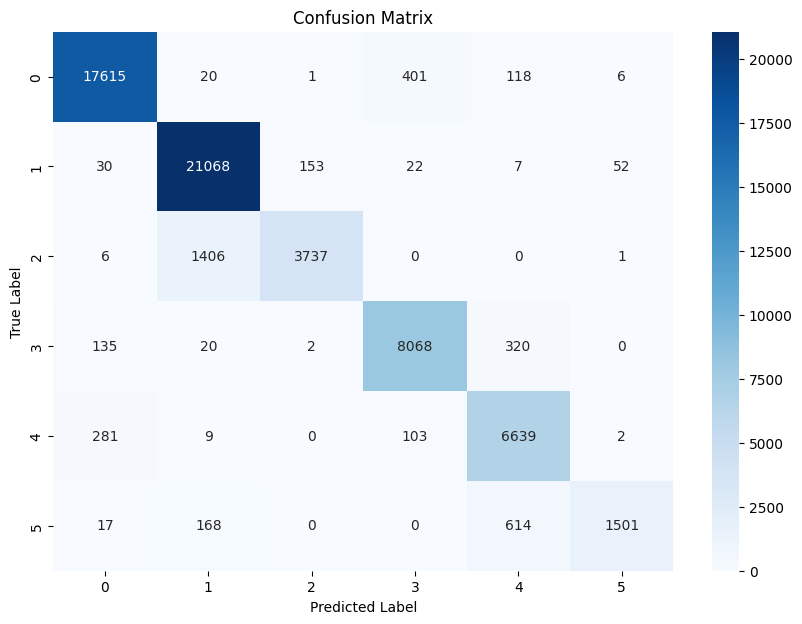

Test Loss: 0.0918, Test Accuracy: 0.9377


In [ ]:
# Окончательная оценка на тестовой выборке
test_dataset = TwitterDataset(test_texts, test_labels, tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, test_acc = eval_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

**0.94, друзья!**

Очень радует потемневшая диагональ матрицы - классы определяются корректно!

Да, любовь(2) и радость(1) все еще в близких отношениях, ну и замечательно:)

Протестируем сами!

In [ ]:
from transformers import AutoTokenizer
import torch

def predict_class(text, model, tokenizer, max_len=128, device='cpu'):
    # Переключение модели в режим оценки
    model.eval()

    # Подготовка данных
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Предсказание
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.softmax(dim=1)  # Применение softmax для вероятностей
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

In [ ]:
def predict(text):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  predicted_class = predict_class(text, model, tokenizer, device=device)
  print(f"Predicted class: {predicted_class}")

In [ ]:
predict("i hate school.")

Predicted class: 3


In [ ]:
predict("the best day of my life!")

Predicted class: 1


In [ ]:
predict("hahaha you are a joke")

Predicted class: 3


In [ ]:
predict("i surely hate this guy")

Predicted class: 3


In [ ]:
predict("there is nothing worse than this in the world.")

Predicted class: 0


In [ ]:
predict("i just love when this happens!")

Predicted class: 1


In [ ]:
predict("i'm actually trembling from these news")

Predicted class: 4


In [ ]:
predict("i am scared for my children")

Predicted class: 4


In [ ]:
predict("surprising")

Predicted class: 5


# Выводы

Это было здорово!

Задача мультиклассификации была решена двумя способами:


1.   Классический пайплайн
2.   Предобученные модели



Для нейросетевого подхода было протестировано 4 разные модели из HuggingFace. В ходе их использования мы столкнулись с тремя ограничивающими факторами:

1. Лимит на использование GPU
2. Ограниченность RAM
3. Большой размер датасета - 417000 строк

Для эффективного использования имеющихся ресурсов приходилось активно манипулировать параметрами обработки данных: распределять нагрузку между средами выполнения CPU и GPU, разбивать данные на батчи, контролировать количество параллельных процессов (num_workers), собирать мусор с помощью gc, находить баланс между скоростью обучения моделей и качеством их метрик.

Наиболее качественным решением в задачах извлечения эмбеддингов и дообучения в условиях ограниченности ресурсов стала модель [TaylorAI/bge-micro-v2](https://huggingface.co/TaylorAI/bge-micro-v2).

Напомним ее результаты:
1. Эмбеддинги, пропущенные через логистическую регрессию и метод опорных векторов, отдали точность в **0.71**.
2. Дообучение модели обеспечило скору **0.94**.